<a href="https://www.kaggle.com/code/averma111/lightning-timeseries?scriptVersionId=136707576" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [171]:
# Re-loads all imports every time the cell is ran. 
%reload_ext autoreload

from time import time

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format

from IPython.display import display

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Networks
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [172]:
class TimeseriesDataset(Dataset):   
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [173]:
from sklearn.preprocessing import LabelEncoder
class ForecastingDataModule(pl.LightningDataModule):
    
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=0):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None

    def prepare_data(self):
        path = '/kaggle/input/playground-series-s3e19/train.csv'
        df = pd.read_csv(
            path, 
            sep=',', 
            parse_dates=['date'], 
            infer_datetime_format=True, 
            low_memory=False
        )

        X = df.copy()
        X['store'] =  LabelEncoder().fit_transform(X['store'])
        X['product'] =  LabelEncoder().fit_transform(X['product'])
        X['country'] =  LabelEncoder().fit_transform(X['country'])
        X = X.loc[:, X.columns!='id']
        y = X['num_sold']
        X.drop(columns=['date','num_sold'],axis=1,inplace=True)
        self.columns = X.columns
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.25, shuffle=False
        )
        #print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)
        self.X_train=X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val

    def setup(self, stage=None):
        preprocessing = StandardScaler()
        if stage == 'fit':
            self.X_train = preprocessing.fit_transform(self.X_train)
            self.y_train = self.y_train.values
            self.X_val = preprocessing.fit_transform(self.X_val)
            self.y_val = self.y_val.values

        if stage == 'test':
            self.X_test = preprocessing.fit_transform(X_test)
            
        

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train, 
                                          self.y_train, 
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False, 
                                  num_workers = self.num_workers)
        
        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val, 
                                        self.y_val, 
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False, 
                                num_workers = self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test, 
                                         self.y_test, 
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

        return test_loader

In [183]:
class LSTMRegressor(pl.LightningModule):
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('Train_loss', loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('Validation_loss', loss)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.EvalResult()
        result.log('Test_loss', loss)
        return result

In [184]:
p = dict(
    seq_len = 24,
    batch_size = 70, 
    criterion = nn.MSELoss(),
    max_epochs = 10,
    n_features = 3,
    hidden_size = 100,
    num_layers = 1,
    dropout = 0.2,
    learning_rate = 0.001,
)

In [185]:
seed_everything(1)
csv_logger = CSVLogger('./', name='lstm', version='0'),

model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)



In [186]:
print(model)

LSTMRegressor(
  (criterion): MSELoss()
  (lstm): LSTM(3, 100, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [187]:
trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    accelerator='auto',
    log_every_n_steps=1
)

In [188]:
dm = ForecastingDataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)
dm.prepare_data()


Type:        NoneType
String form: None
Namespace:   Python builtin
Docstring:   <no docstring>

In [189]:
trainer.fit(model, dm)


(102712, 3) (102712,) (34238, 3) (34238,)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

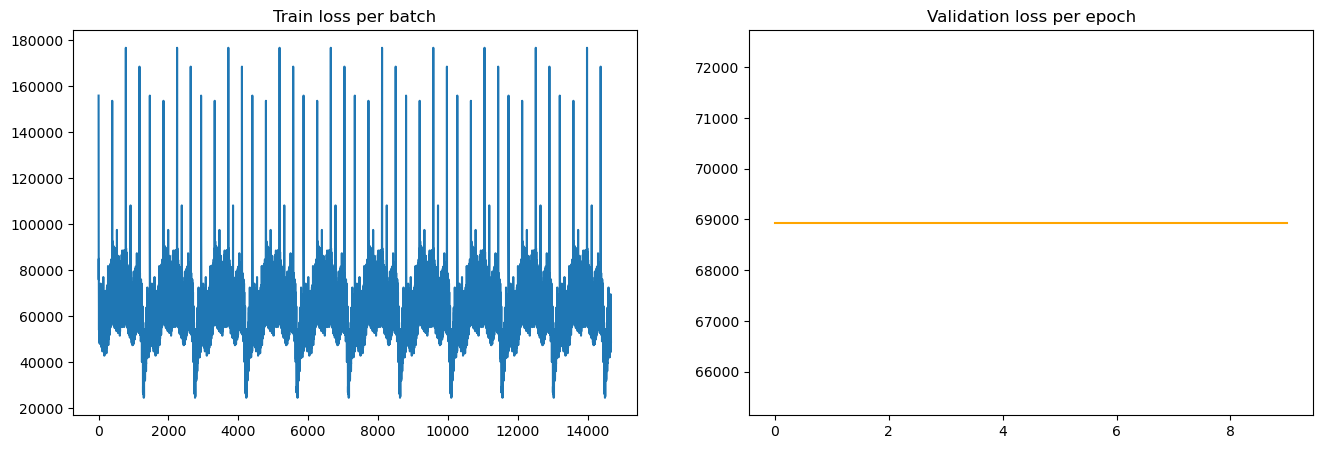

MSE:
Train loss: 48736.223
Val loss:   68935.336


In [192]:
metrics = pd.read_csv('./lstm/0/metrics.csv')
train_loss = metrics[['Train_loss', 'step', 'epoch']][~np.isnan(metrics['Train_loss'])]
val_loss = metrics[['Validation_loss', 'epoch']][~np.isnan(metrics['Validation_loss'])]
#test_loss = metrics['Test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['Train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['Validation_loss'], color='orange')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['Train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['Validation_loss'].iloc[-1]:.3f}")
#print(f'Test loss:  {test_loss:.3f}')

In [ ]:
trainer.test(model, datamodule=dm)

In [191]:
temp = pd.read_csv('/kaggle/working/lstm/0/metrics.csv')
temp

,Train_loss,epoch,step,Validation_loss
0,"155,952.60938",0,0,NaN
1,"96,592.96875",0,1,NaN
2,"92,639.68750",0,2,NaN
3,"87,304.29688",0,3,NaN
4,"77,170.82812",0,4,NaN
...,...,...,...,...
14675,"44,721.19922",9,14666,NaN
14676,"51,641.94531",9,14667,NaN
14677,"51,362.87891",9,14668,NaN
14678,"48,736.22266",9,14669,NaN
